# Resume Job Postings

3. Finding clusters of jobs

In [1]:
# Setup
import pandas as pd
import numpy as np

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import Normalizer

from tqdm.notebook import tqdm
import matplotlib.cm as cm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load pickle file from step 2
most_similar_df = pd.read_pickle('step2_df.pk')
most_similar_df.head()

,title,body,bullets,cosine_similarity
0,Data Science Health Innovation Fellow Job - BI...,Data Science Health Innovation Fellow Job - BI...,"(Demonstrated ability to propose, initiate, an...",0.155612
1,Machine Learning Postdoctoral Fellow - San Fra...,Machine Learning Postdoctoral Fellow - San Fra...,(Design and develop distributed machine learni...,0.146193
2,Post-doc: Dissemination/implementation and/or ...,Post-doc: Dissemination/implementation and/or ...,(),0.091850
3,"Machine Learning Intern - San Diego, CA","Machine Learning Intern - San Diego, CA\nInnov...",(Design and develop machine learning models to...,0.085786
4,Data Science Summer Institute Student Intern -...,Data Science Summer Institute Student Intern -...,"(Students will work with scientists, engineers...",0.083359


In [3]:
# Use bullets to analyze skill requirements
bullet_points = [item for sublist in most_similar_df['bullets'] for item in sublist]
len(bullet_points)

1730

In [4]:
# Remove stop words
bullet_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_skills = bullet_vectorizer.fit_transform(bullet_points)
tfidf_skills.shape

(1730, 2647)

In [5]:
# Dimension reduction
dim = 500 # max value of (tfidf_skills.shape[1] - 1)
svd = TruncatedSVD(n_components=dim)

lsa = svd.fit_transform(tfidf_skills)

In [6]:
# total variance explained with 500 dimensions instead of 2647
svd.explained_variance_ratio_.sum()

0.7999116996366904

In [7]:
# How many dimensions explain 50% of the variance
(svd.explained_variance_ratio_.cumsum() <= 0.5).sum()

159

array([0.01020246, 0.02441753, 0.03858982, 0.05207327, 0.06411358,
       0.07286097, 0.08132931, 0.08883867, 0.09600563, 0.10300971])

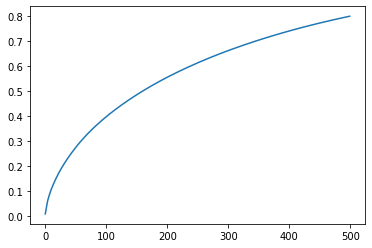

In [8]:
# Check how evolve the variance with all dimensions
plt.plot(range(svd.explained_variance_ratio_.shape[0]), svd.explained_variance_ratio_.cumsum())
svd.explained_variance_ratio_.cumsum()[:10]

In [9]:
# Check variance explained with 100 dimensions
svd.explained_variance_ratio_[:100].sum()

0.3966996643026933

In [10]:
# Normalize the results with only 100 components
svd = TruncatedSVD(n_components=100)
lsa = svd.fit_transform(tfidf_skills)
norm = Normalizer().fit_transform(lsa) # Normalization makes KMeans behave as spherical for better results

In [11]:
# Cluster using KMeans. Identify number of clusters
wss = []
silhouette = []
clusters = range(2, 51)
for c in tqdm(clusters):
    km = KMeans(n_clusters=c, random_state=42)
    km.fit(norm)
    # sklearn kmeans wss is negative
    wss.append(-km.score(norm))
    silhouette.append(silhouette_score(norm, km.labels_))

  0%|          | 0/49 [00:00<?, ?it/s]

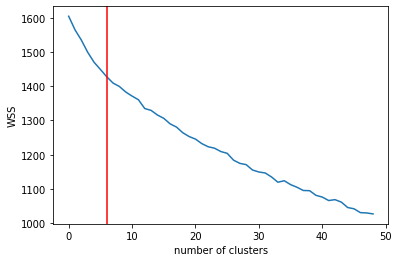

In [12]:
metrics = pd.DataFrame({'wss': wss, 'silhouette': silhouette})
# Plot number of cluster
metrics['wss'].plot()
plt.xlabel('number of clusters')
plt.ylabel('WSS')
_ = plt.axvline(6, c='r')

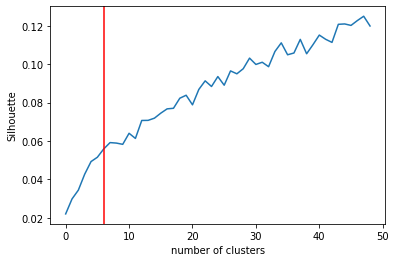

In [13]:
# Plot silhouette
metrics['silhouette'].plot()
plt.xlabel('number of clusters')
plt.ylabel('Silhouette')
_ = plt.axvline(6, c='r')

In [14]:
def silhouette_analysis(k):
    """Plot the silhouette of k number of clusters.
    """
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(norm)
    cluster_labels = km.labels_
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(norm, cluster_labels)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(norm, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([]) # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

For n_clusters = 5 The average silhouette_score is : 0.04273118424744903


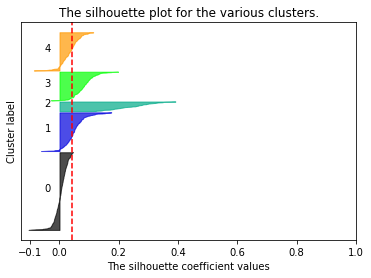

In [15]:
# plot for 5 clusters
silhouette_analysis(5)

For n_clusters = 6 The average silhouette_score is : 0.049301553948126166


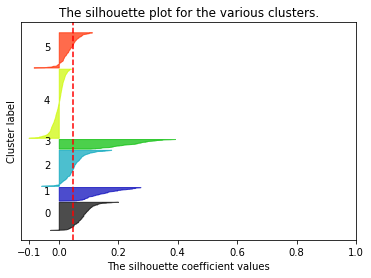

In [16]:
# plot for 6 clusters
silhouette_analysis(6)

In [17]:
clusters = 5
km = KMeans(n_clusters=clusters, random_state=42)
km.fit(norm)
cluster_labels_df = pd.DataFrame({'Cluster': km.labels_})
cluster_labels_df.head()

,Cluster
0,0
1,0
2,0
3,2
4,0


In [18]:
def rank_words_by_tfidf(indices, tfidf_matrix=tfidf_skills, word_list=bullet_vectorizer.get_feature_names()):
    """
    Takes indices for a tfidf matrix, sums the TFIDF across the matrix, and returns
    a pandas DataFrame with words ranked from the highest summed TFIDF values down to lowest.
    The indices argument is intended to be used to filter the DataFrame by kmeans clusters.
    """
    summed_tfidf = np.asarray(tfidf_matrix[indices].sum(axis=0))[0]
    data = {'Word': word_list, 'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)

C:\Users\sebastian.buitrago\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
def cluster_to_image(df_cluster, max_words=15):
    indices = df_cluster.index.values
    # Get TFIDF-ranked words
    df_ranked_words = rank_words_by_tfidf(indices)[:max_words]

    # Create word-to-TFIDF value dictionary for the word cloud
    words_to_score = {word: score for word, score in df_ranked_words[:max_words].values if score != 0}
    
    # Generate the word cloud
    cloud_generator = WordCloud(background_color='white', color_func=_color_func, random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    
    return wordcloud_image, words_to_score

def _color_func(*args, **kwargs):
    # a small function to change the color of the word clouds
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

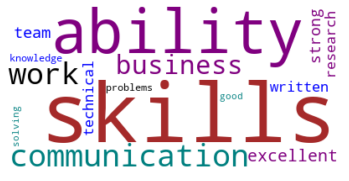

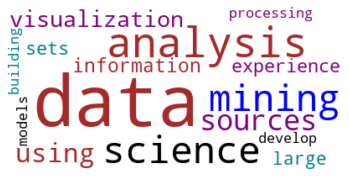

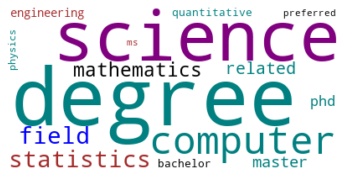

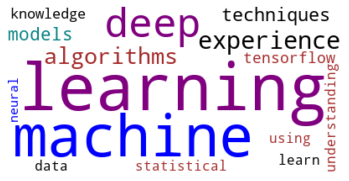

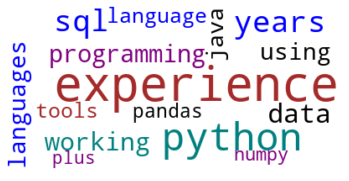

In [20]:
docs_in_clusters = []
word_dictionaries = []
for c in range(clusters):
    df_cluster = cluster_labels_df[cluster_labels_df.Cluster == c]

    wordcloud_image, words_to_score = cluster_to_image(df_cluster)
    word_dictionaries.append(words_to_score)
    plt.imshow(wordcloud_image, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    # Get the number of documents in each cluster
    # for analysis of how well distributed the clusters are
    docs = np.where(km.labels_ == c)[0]
    docs_in_clusters.append(len(docs))

In [21]:
def plot_word_dict(word_dict):
    """
    Plots frequency distribution of word-to-TFIDF score dictionaries.
    """
    plt.figure()
    x = range(len(word_dict.values()))
    plt.plot(x, list(word_dict.values()))
    plt.xticks(x, word_dict.keys(), rotation=90)
    plt.ylabel('summed TFIDF value')

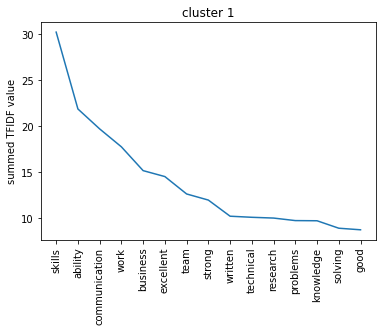

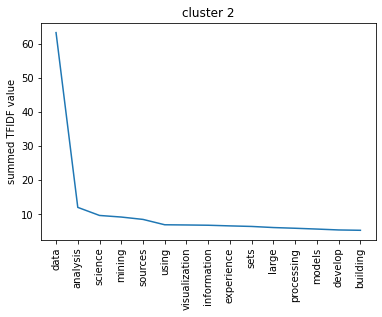

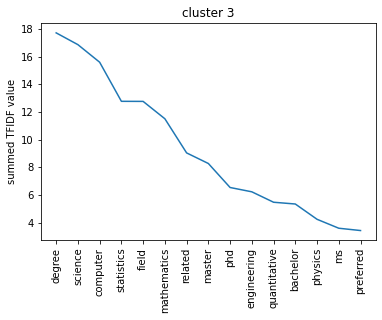

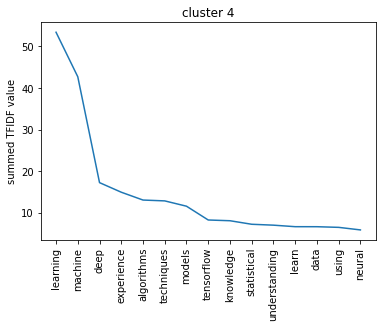

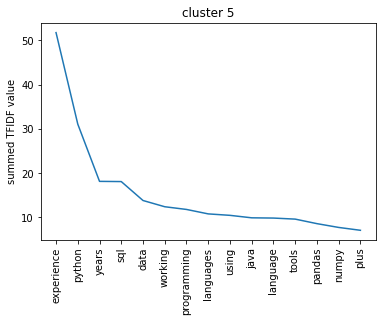

In [22]:
for c in range(len(word_dictionaries)):
    plot_word_dict(word_dictionaries[c])
    plt.title('cluster {}'.format(c + 1))

Text(0, 0.5, 'Num bullets (Requirements)')

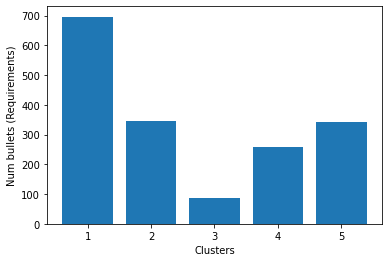

In [23]:
_ = plt.bar(range(1, clusters + 1), docs_in_clusters)
plt.xlabel('Clusters')
plt.ylabel('Num bullets (Requirements)')

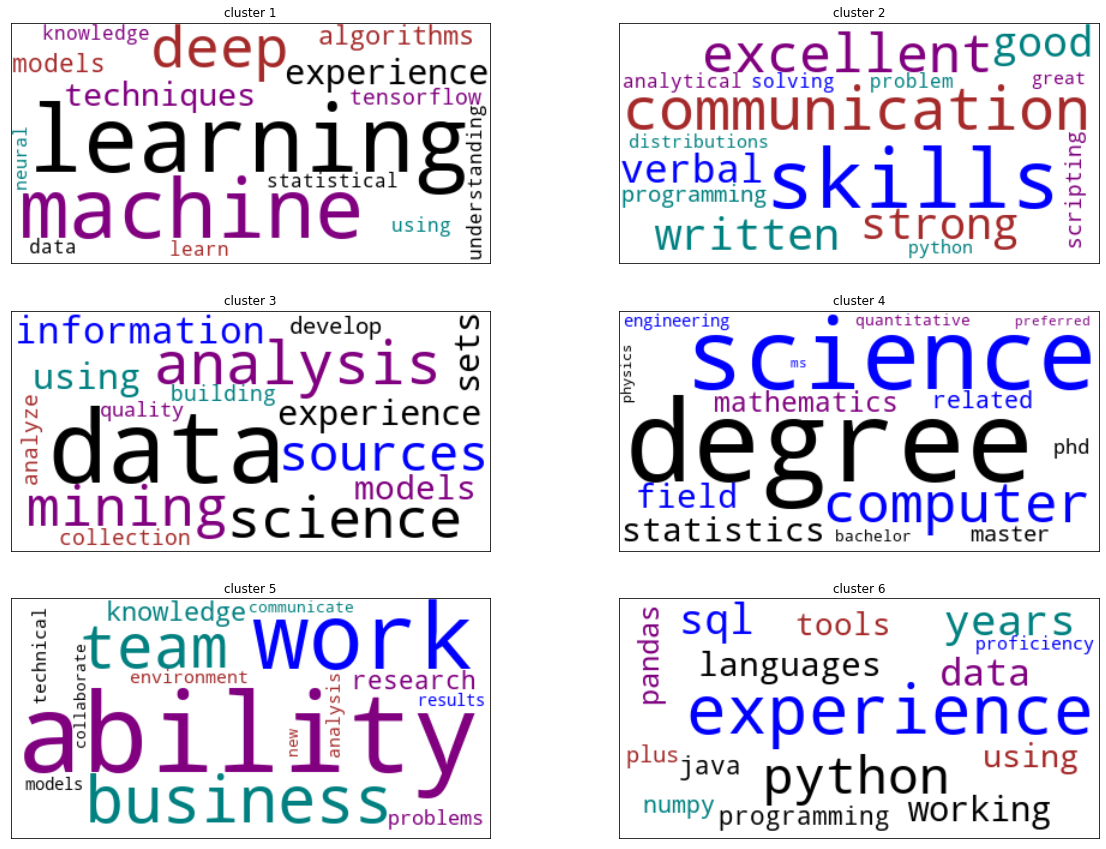

In [24]:
# Plot all clusters and wordclouds together
km = KMeans(n_clusters=6, random_state=42)
km.fit(norm)
labels = km.labels_
df_cluster_labels = pd.DataFrame({'Index': range(labels.size), 'Cluster': labels})

rows, cols = 3, 2
figure, axes = plt.subplots(rows, cols, figsize=(20, 15))
cluster_groups = list(df_cluster_labels.groupby('Cluster'))
cluster_counter = 0
for r in range(rows):
    for c in range(cols):
        cluster_counter += 1
        _, df_cluster = cluster_groups.pop(0)
        wordcloud_image, words_to_score = cluster_to_image(df_cluster)
        ax = axes[r][c]
        ax.imshow(wordcloud_image, interpolation="bilinear")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('cluster {}'.format(cluster_counter))

plt.show()

In [25]:
# Compare with a few job descriptions
bullet_point_df = pd.DataFrame({'bullet_point': bullet_points}, index=range(len(bullet_points)))
# set seed for reproducibility in random sampling
np.random.seed(42)

for c in range(6):
    cluster_indices = cluster_labels_df[cluster_labels_df['Cluster'] == c].index
    cluster_bullet_points = bullet_point_df.loc[cluster_indices, 'bullet_point'].values
    try:
        random_bullets = np.random.choice(cluster_bullet_points, 3)
        print('3 random bullet points from cluster {}:'.format(c + 1))
        for r in random_bullets:
            print('-', r)
            print('\n')
    except: # when the bullet is empty
        pass

3 random bullet points from cluster 1:
- Knowledge of any of the following: Natural Language Processing & Text Mining, Experimental Design, Bayesian Networks, Network/Graph Mining is a plus


- Cover Letter


- Demonstrated analytic agility


3 random bullet points from cluster 2:
- Design strategies and propose algorithms to analyze and leverage data from existing as well as new data sources.


- Detailed and clear understanding of data used in all analytics projects (including visualizations that help others gain clarity for decision-making)


- Perform data exploration to uncover relationships and trends in data


3 random bullet points from cluster 3:
- Degree in computer science, software engineering, statistics, machine learning, bioinformatics or related technical field


- Currently has or is in the process of obtaining a PhD in machine learning, computer vision, speech processing, applied statistics, computational neuroscience, or a related field.


- MS or PhD degree in Compu

In [28]:
# Save files for next step
cluster_labels_df.to_pickle('cluster_labels_df.pk')
bullet_point_df.to_pickle('bullet_point_df.pk')